In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu

In [3]:
from keras.layers import Input, LSTM, Embedding, Dense,Flatten
from keras.models import Model
from keras import optimizers
from keras.callbacks import callbacks

Using TensorFlow backend.


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
train_df=pd.read_csv('new_processed_hindi_english.csv') 
train_df.head()

,english,hindi,processed_hindi,processed_english,len_processed_hindi,len_processed_english
0,Wow!,वाह!,वाह,wow,1,1
1,Help!,बचाओ!,बचाओ,help,1,1
2,Jump.,उछलो.,उछलो,jump,1,1
3,Jump.,कूदो.,कूदो,jump,1,1
4,Jump.,छलांग.,छलांग,jump,1,1


In [6]:
train_df['encoder_input'] ='<start>'+' '+train_df['processed_english']+' '+'<end>'
train_df['decoder_input'] ='<start>'+' '+train_df['processed_hindi']+' '+'<end>'
train_df['decoder_output'] = train_df['processed_hindi']+' '+'<end>'+' '+'<end>'

In [7]:
train_df.shape

(13815, 9)

In [8]:
train_df.head()

,english,hindi,processed_hindi,processed_english,len_processed_hindi,len_processed_english,encoder_input,decoder_input,decoder_output
0,Wow!,वाह!,वाह,wow,1,1,<start> wow <end>,<start> वाह <end>,वाह <end> <end>
1,Help!,बचाओ!,बचाओ,help,1,1,<start> help <end>,<start> बचाओ <end>,बचाओ <end> <end>
2,Jump.,उछलो.,उछलो,jump,1,1,<start> jump <end>,<start> उछलो <end>,उछलो <end> <end>
3,Jump.,कूदो.,कूदो,jump,1,1,<start> jump <end>,<start> कूदो <end>,कूदो <end> <end>
4,Jump.,छलांग.,छलांग,jump,1,1,<start> jump <end>,<start> छलांग <end>,छलांग <end> <end>


In [9]:
max_len_eng = int(np.percentile(train_df['len_processed_english'],95))+2
max_len_eng

13

In [10]:
max_len_hindi =int(np.percentile(train_df['len_processed_hindi'],95))+2
max_len_hindi

14

In [11]:
train_df=train_df[train_df['len_processed_hindi']<=max_len_eng]

In [12]:
train_df.shape

(13511, 9)

In [13]:
train_df=train_df[train_df['len_processed_english']<=max_len_hindi]

In [14]:
train_df.shape

(13496, 9)

In [15]:
train_df.dtypes

english                  object
hindi                    object
processed_hindi          object
processed_english        object
len_processed_hindi       int64
len_processed_english     int64
encoder_input            object
decoder_input            object
decoder_output           object
dtype: object

In [16]:
train_df['encoder_input']=train_df.encoder_input.astype(str)
train_df['decoder_input']=train_df.decoder_input.astype(str)
train_df['decoder_output']=train_df.decoder_output.astype(str)

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, test_size=0.15,random_state=42)
# train, cv = train_test_split(train, test_size=1/9,random_state=42)

In [18]:
train.shape,test.shape

((11471, 9), (2025, 9))

In [19]:
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['encoder_input'].values)

vocab_size_eng = len(tknizer_eng.word_index) + 1
vocab_size_eng,max_len_eng

(4177, 13)

In [20]:
tknizer_hindi = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_hindi.fit_on_texts(train['decoder_input'].values)

vocab_size_hindi = len(tknizer_hindi.word_index) + 1
vocab_size_hindi,max_len_hindi

(5672, 14)

In [21]:
tknizer_eng.word_index['<start>'],tknizer_eng.word_index['<end>']

(1, 2)

In [22]:
tknizer_eng.index_word[1],tknizer_eng.index_word[2]

('<start>', '<end>')

In [23]:
X_train_e=tknizer_eng.texts_to_sequences(train['encoder_input'])
X_train_h=tknizer_hindi.texts_to_sequences(train['decoder_input'])
y_train_h=tknizer_hindi.texts_to_sequences(train['decoder_output'])

X_test_e=tknizer_eng.texts_to_sequences(test['encoder_input'])
X_test_h=tknizer_hindi.texts_to_sequences(test['decoder_input'])
y_test_h=tknizer_hindi.texts_to_sequences(test['decoder_output']) 

In [24]:
X_train_e=pad_sequences(X_train_e,maxlen=max_len_eng,padding='post')
X_train_h=pad_sequences(X_train_h,maxlen=max_len_hindi,padding='post')
y_train_h=pad_sequences(y_train_h,maxlen=max_len_hindi,padding='post')

X_test_e=pad_sequences(X_test_e,maxlen=max_len_eng,padding='post')
X_test_h=pad_sequences(X_test_h,maxlen=max_len_hindi,padding='post')
y_test_h=pad_sequences(y_test_h,maxlen=max_len_hindi,padding='post') 

In [25]:
X_train_e.shape,X_train_h.shape,y_train_h.shape,X_test_e.shape,X_test_h.shape,y_test_h.shape

((11471, 13), (11471, 14), (11471, 14), (2025, 13), (2025, 14), (2025, 14))

In [26]:
print(X_train_e.shape)
X_train_e

(11471, 13)


array([[   1,  211,    2, ...,    0,    0,    0],
       [   1,   29,  298, ...,    0,    0,    0],
       [   1,    5,  522, ..., 2728,    2,    0],
       ...,
       [   1,   10,    3, ...,    0,    0,    0],
       [   1,   10,   21, ...,    0,    0,    0],
       [   1,   45,   21, ...,    0,    0,    0]])

In [27]:
print(X_train_h.shape)
X_train_h

(11471, 14)


array([[   1,  187,    2, ...,    0,    0,    0],
       [   1,  178,   11, ...,    0,    0,    0],
       [   1,  424,   28, ..., 1314,   54,    2],
       ...,
       [   1,    8,   66, ...,    0,    0,    0],
       [   1,    8,   19, ...,    0,    0,    0],
       [   1,   56,   22, ...,    0,    0,    0]])

In [28]:
y_train_h

array([[ 187,    2,    2, ...,    0,    0,    0],
       [ 178,   11,   13, ...,    0,    0,    0],
       [ 424,   28, 2279, ...,   54,    2,    2],
       ...,
       [   8,   66, 3403, ...,    0,    0,    0],
       [   8,   19,  300, ...,    0,    0,    0],
       [  56,   22,  253, ...,    0,    0,    0]])

In [29]:
def generate_batch(X_e,X_h,y_h,batch_size):
    while True:
        for i in range(0,X_e.shape[0]//batch_size):
            encoder_input = X_e[i*batch_size:(i+1)*batch_size]
            decoder_input = X_h[i*batch_size:(i+1)*batch_size]
            decoder_output_= y_h[i*batch_size:(i+1)*batch_size]
            decoder_output=np.zeros((batch_size,max_len_hindi,vocab_size_hindi))
            for i in range(batch_size):
                for j in range(max_len_hindi):
                    k=decoder_output_[i][j]
                    decoder_output[i][j][k]=1
            yield([encoder_input, decoder_input], decoder_output)    

In [30]:
#early stopping
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1,mode='min')

In [31]:
class LossHistory(callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'val_loss': []}
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
            
history_own=LossHistory()   

In [32]:
from keras.callbacks import LearningRateScheduler
def changeLearningRate(epoch,lr):
    if len(history_own.history['val_loss'])>1: #check if there there two elements   
        if(history_own.history['val_loss'][-1] > history_own.history['val_loss'][-2]): 
            return(lr-(0.1*lr))
    if ((epoch+1)%10)==0 and epoch!=0:
        return(lr-(0.05*lr))
    else:
        return lr
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

In [33]:
callback_list = [history_own,earlystop,lrschedule] 

In [34]:
embedding_dim=100
lstm_units=100
batch_size=64

In [35]:
# Encoder
encoder_inputs = Input(shape=(None,))
print('Encoder input : ',encoder_inputs.shape)
enc_emb =  Embedding(vocab_size_eng,embedding_dim)(encoder_inputs)
print('Encoder after embedding layer : ',enc_emb.shape)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
print('Encoder output after lstm : ',encoder_outputs.shape)
print('Encoder state_h after lstm : ',state_h.shape)
print('Encoder state_c after lstm : ',state_c.shape)
print('-'*40)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Encoder input :  (?, ?)
Encoder after embedding layer :  (?, ?, 100)
Encoder output after lstm :  (?, 100)
Encoder state_h after lstm :  (?, 100)
Encoder state_c after lstm :  (?, 100)
----------------------------------------


In [36]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
print('Decoder inputs : ',decoder_inputs.shape)
dec_emb_layer = Embedding(vocab_size_hindi,embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
print('Decoder after embedding layer : ',dec_emb.shape)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
print('Decoder outputs after lstm : ',decoder_outputs.shape)
decoder_dense = Dense(vocab_size_hindi, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print('Decoder outputs after dense layer : ',decoder_outputs.shape)
print('-'*40)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Decoder inputs :  (?, ?)
Decoder after embedding layer :  (?, ?, 100)
Decoder outputs after lstm :  (?, ?, 100)
Decoder outputs after dense layer :  (?, ?, 5672)
----------------------------------------


In [37]:
rmsprop=optimizers.rmsprop()
model.compile(optimizer=rmsprop, loss='categorical_crossentropy')

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    417700      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    567200      input_2[0][0]                    
____________________________________________________________________________________________

In [39]:
# from IPython.display import Image
# Image(retina=True, filename='train_model.png')

In [40]:
train_samples = len(X_train_e)
val_samples = len(X_test_e)
epochs = 200

In [41]:
model.fit_generator(generator = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,callbacks=callback_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
179/179 [==============================] - 59s 328ms/step - loss: 3.5818 - val_loss: 2.7537
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
179/179 [==============================] - 58s 321ms/step - loss: 2.7671 - val_loss: 2.5858
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
179/179 [==============================] - 59s 328ms/step - loss: 2.6172 - val_loss: 2.4839
Epoch 4/200

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
179/179 [==============================] - 60s 333ms/step - loss: 2.5075 - val_loss: 2.3975
Epoch 5/200

Epoch 00005: LearningRateScheduler setting learning rate to 0.0010000000474974513.
179/179 [==============================] - 60s 333ms/step

In [42]:
# model.save_weights('nmt_weights_20e1-new.h5')

In [43]:
# model.load_weights('nmt_weights_20e1-new.h5')

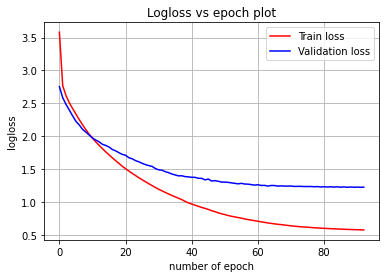

In [44]:
plt.plot(history_own.history['loss'], 'r')
plt.plot(history_own.history['val_loss'], 'b')
plt.legend({'Train loss': 'r', 'Validation loss':'b'})
plt.ylabel('logloss')
plt.xlabel('number of epoch')
plt.title('Logloss vs epoch plot')
plt.grid()
plt.show()

In [45]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
 
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = tknizer_hindi.word_index['<start>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tknizer_hindi.index_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<end>'):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [47]:
def index_to_text(x,dictionary):
    s=''
    for i in x[0]:
        if i==0:
            break
        if dictionary[i]=='<end>' or dictionary[i]=='<start>':
            continue
        s+=dictionary[i]+' '
    return s

In [109]:
s1='चाहो तो तुम जा सकती हो'
s2='चाहो तो तुम जा सकती हो <end>'

In [112]:
score = sentence_bleu([s1.split()],s2.replace('<end>','').split())
score

1.0

In [73]:
train_gen = generate_batch(X_train_e,X_train_h,y_train_h, batch_size = 1)

In [74]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  really 
Actual Hindi Translation:  सच 
Predicted Hindi Translation:  सच <end>
BLEU Score :  1.821831989445342e-231


In [75]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  we tried to save tom 
Actual Hindi Translation:  हमने टॉम को बचाने की कोशिश की 
Predicted Hindi Translation:  टॉम को तुम्हें पता पड़ेगी <end>
BLEU Score :  5.6228231334895985e-155


In [76]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  the police tried hard to unravel the mystery of killing 
Actual Hindi Translation:  पुलिस ने हत्या की गुथी को सुलझाने के लिए कड़ा प्रयास किया 
Predicted Hindi Translation:  पुलिस ने पुलिस को किसी को साल कर दिया कि तुमने ठीक से दिया था <end>
BLEU Score :  5.157006819435075e-155


In [77]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  do you have brothers and sisters 
Actual Hindi Translation:  तुम्हारे पास भाई बहन हैं क्या 
Predicted Hindi Translation:  तुम्हारे पास भाई बहन हैं क्या <end>
BLEU Score :  1.0


In [78]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  your room is ready 
Actual Hindi Translation:  आपका कमरा तैयार है 
Predicted Hindi Translation:  आपका कमरा तैयार है <end>
BLEU Score :  1.0


In [79]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  have you seen tom today no i have not 
Actual Hindi Translation:  आज टॉम को देखा नहीं नहीं देखा 
Predicted Hindi Translation:  आज टॉम को देखा नहीं नहीं देखा <end>
BLEU Score :  1.0


In [80]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  do as tom says 
Actual Hindi Translation:  टॉम जैसा कहे वैसा कीजिए 
Predicted Hindi Translation:  टॉम जैसा कहे वैसा करो <end>
BLEU Score :  0.668740304976422


In [81]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he prefers french to german 
Actual Hindi Translation:  उसे फ़्रानसीसी जर्मन से ज़्यादा अच्छी लगती है 
Predicted Hindi Translation:  वह शहर में शहर करना चाहती क्यों नहीं <end>
BLEU Score :  0


In [82]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  it is no use crying over spilt milk 
Actual Hindi Translation:  अब पछताए क्या होत जब चिड़िया चुग गई खेत 
Predicted Hindi Translation:  उसके क्या चाहिए <end>
BLEU Score :  1.8734367966736672e-232


In [83]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  i do a lot of things 
Actual Hindi Translation:  मैं बहुत सारे चीज़ें करता हूँ 
Predicted Hindi Translation:  मैं बहुत सारे <end>
BLEU Score :  4.493053873107152e-78


In [84]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  i am going to go to america next year 
Actual Hindi Translation:  अगले साल मैं अमरीका जाने वाला हूँ 
Predicted Hindi Translation:  मैं अगले हफ़्ते से बारे में बहुत रहा हूँ <end>
BLEU Score :  1.384292958842266e-231


In [85]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  a good idea suddenly struck her 
Actual Hindi Translation:  अचानक उसे एक अच्छा आइडिया आया 
Predicted Hindi Translation:  अचानक उसे एक अच्छा लगता है <end>
BLEU Score :  0.5081327481546147


In [86]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  what kind of people do you like best 
Actual Hindi Translation:  आपको किस तरह के लोग सबसे ज़्यादा पसंद हैं 
Predicted Hindi Translation:  तुम्हारे पास जर्मनी में समय क्या है <end>
BLEU Score :  0


In [87]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he cut the envelope open 
Actual Hindi Translation:  उसने लिफ़ाफ़े को काटकर खोल दिया 
Predicted Hindi Translation:  उसने पैसों की कमी थी <end>
BLEU Score :  9.97486269044271e-232


In [88]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  if you wish you can go 
Actual Hindi Translation:  चाहो तो तुम जा सकती हो 
Predicted Hindi Translation:  चाहो तो तुम जा सकती हो <end>
BLEU Score :  1.0


In [89]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  say goodbye 
Actual Hindi Translation:  अलविदा कहिए 
Predicted Hindi Translation:  पार्टी गई <end>
BLEU Score :  0


In [90]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  what do you know about germany 
Actual Hindi Translation:  आपको जर्मनी के बारे में क्या मालूम है 
Predicted Hindi Translation:  तुम जर्मनी के बारे में क्या जानते हो <end>
BLEU Score :  0.5169731539571706


In [91]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he knocked at the door 
Actual Hindi Translation:  उसने दरवाज़े पर खटखटाया 
Predicted Hindi Translation:  उसने दरवाज़े पर खटखटाया <end>
BLEU Score :  1.0


In [92]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  may we accompany you on your walk 
Actual Hindi Translation:  हम तुम्हारे साथ सैर करने चलें क्या 
Predicted Hindi Translation:  हम तुम्हारे साथ सैर करने चलें क्या <end>
BLEU Score :  1.0


In [93]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  why did you come here this morning 
Actual Hindi Translation:  तुम आज सुबह यहाँ क्यों आए 
Predicted Hindi Translation:  तुम यहाँ क्यों भी क्यों आए हो <end>
BLEU Score :  9.85444998995587e-155


In [94]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he made up an excuse 
Actual Hindi Translation:  उसने कोई बहाना बना लिया 
Predicted Hindi Translation:  उसने कोई बहाना बना लिया <end>
BLEU Score :  1.0


In [95]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  somebody is watching us 
Actual Hindi Translation:  किसी की हम पर नज़र है 
Predicted Hindi Translation:  कोई हमारे साथ आ रहा है <end>
BLEU Score :  1.1640469867513693e-231


In [96]:
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  the novel is very exciting 
Actual Hindi Translation:  यह उपन्यास बहुत रोमांचक है 
Predicted Hindi Translation:  यह उपन्यास बहुत है <end>
BLEU Score :  7.227401369829121e-78


In [113]:
test_gen = generate_batch(X_test_e,X_test_h,y_test_h, batch_size = 1)

In [117]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he seems to know us 
Actual Hindi Translation:  लगता है वह हमें जानता है 
Predicted Hindi Translation:  वह हमें पता है <end>
BLEU Score :  6.397495320955232e-155


In [118]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  you have got to stop tom 
Actual Hindi Translation:  तुम्हे टॉम को रोकना ही होगा 
Predicted Hindi Translation:  तुम ने टॉम को हमारी मदद करना सबसे सहायक उससे लिए <end>
BLEU Score :  5.477489369001354e-155


In [119]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  what do you want me to do 
Actual Hindi Translation:  तुम मुझसे क्या करवाना चाहते हो 
Predicted Hindi Translation:  क्या तुम मुझसे करना चाहते हो <end>
BLEU Score :  1.133422688662942e-154


In [120]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  the policeman the man open the door 
Actual Hindi Translation:  ने आदमी को दरवाज़ा खोलते देखा 
Predicted Hindi Translation:  यह आदमी की जहाज़ ने उसे साल किया गया <end>
BLEU Score :  1.2508498911928379e-231


In [121]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  he lived there all by himself 
Actual Hindi Translation:  वह वहां अकेले से रहा 
Predicted Hindi Translation:  वे सब से लिए पड़ोस <end>
BLEU Score :  1.2183324802375697e-231


In [122]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  she is busy at present and can not speak to you 
Actual Hindi Translation:  वे अभी व्यस्थ हैं और आपसे बात नहीं कर सकतीं हैं 
Predicted Hindi Translation:  वे अभी तक आपको संगीत लिख रहा है <end>
BLEU Score :  4.4567910894251624e-155


In [123]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  we should love our neighbors 
Actual Hindi Translation:  हमे पड़ोसियों के साथ प्रेमपूर्वक रहना चहिए 
Predicted Hindi Translation:  हमें उसके साथ करना चाहिए ने <end>
BLEU Score :  9.853445011990208e-232


In [124]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  the animals in the forest died off 
Actual Hindi Translation:  जंगल के जानवर मर गए 
Predicted Hindi Translation:  ट्रेन अचानक जा रही थी <end>
BLEU Score :  0


In [125]:
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence: ',index_to_text(input_seq,tknizer_eng.index_word))
print('Actual Hindi Translation: ',index_to_text(actual_output,tknizer_hindi.index_word))
print('Predicted Hindi Translation:', decoded_sentence)
score = sentence_bleu([index_to_text(actual_output,tknizer_hindi.index_word).split()],decoded_sentence.replace('<end>','').split())
print('BLEU Score : ',score)

Input English sentence:  you must not be afraid of making mistakes when learning a language 
Actual Hindi Translation:  कोई भी नई भाषा सीखने में ग़लतियों से डरना नहीं चहिए 
Predicted Hindi Translation:  तुम्हे थोड़ा जाने से दस के पीछे का नहीं बोलना चाहिए <end>
BLEU Score :  1.1896457329133973e-231
